[Дашборд](https://public.tableau.com/app/profile/evgeniia.kupreeva/viz/Final_project_16574331735860/Dashboard1?publish=yes)


[Презентация](https://drive.google.com/file/d/1st_EAreIN2daoxUv9jd-574br6ee0fgQ/view?usp=sharing)

## Описание проекта и цели исследования

Нужно разобраться, как ведут себя пользователи мобильного приложения для продажи ненужных вещей. У нас есть логи событий за некоторый период. В них хранится информация о действиях пользователей.

В ходе исследования изучим данные, ответим на вопросы: 

- какие пользователи склонны часто возвращаться в мобильное приложение?
- какие пользователи часто делают целевое событие (конверсия в целевое действие "contacts_show")
- различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения до contacts_show)?


## Предобработка

In [56]:
# !pip3 install pandas-profiling==2.11
# импортируем библиотеки
import pandas as pd
from datetime import datetime
from pandas_profiling import ProfileReport
import numpy as np
import scipy.stats as st
import math as math

from datetime import datetime, timedelta

import plotly.express as px 
import plotly.graph_objs as go
import seaborn as sns

from matplotlib import pyplot as plt

In [57]:
# подгружаем датасеты
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [58]:
# готовим датасеты к изучению бибиотекой pandas_profiling
profile_sources = ProfileReport(mobile_sourсes, title="Profile sources")
profile_mobile_dataset = ProfileReport(mobile_dataset, title="Mobile dataset")

In [59]:
# запускаем обработку первой таблицы
profile_sources

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет mobile_sources содержит колонки:

- userId — 4293 уникальных  идентификаторов пользователей,
- source — источник, из которого пользователь установил приложение. Принимает 3 значения: yandex(1934 пользователя), google(1129 пользователей) и other(1230 пользователей).

В датасете нет дубликатов и пропущенных значений. Он готов к дальнейшей работе, стоит только привести название колонок к стандартному виду.

In [60]:
# запускаем обработку второго датасета
profile_mobile_dataset

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

mobile_dataset.csv содержит 74197 строк и 3 колонки:
- event.time — время совершения события
- event.name — название события
- user.id — идентификатор пользователя

В этом датасете тоже нет дубликатов строк и пропущенных значений. Имена колонок нужно будет привести к стандартному виду. Значения колонки  event.time приведем к типу datetime.

Число уникальных значений в колонке user.id совпадает с числом userId в mobile_sources, что позволяет нам без проблем объединить два датасета в один.


Колонка event.name содержит 9 видов событий:

- advert_open — открытие карточки объявления
- photos_show — просмотр фотографий в объявлении
- tips_show — пользователь увидел рекомендованные объявления
- tips_click — пользователь кликнул по рекомендованному объявлению
- contacts_show и show_contacts — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call — пользователь позвонил по номеру телефона на карточке объявления
- map — пользователь открыл карту размещенных объявлений
- search_1 — search_7 — разные события, связанные с поиском по сайту
- favorites_add — добавление объявления в избранное

Заметим, что contacts_show и show_contacts суть- одно и то же событие и для дальнейшей работы нужно их объединить. 

Интерес представляет собой соотношение событий (можно посмотреть нажав в разделе event.name кнопку Toggle details, вкладка 
Categories. Для наглядности рисунок выведен ниже).

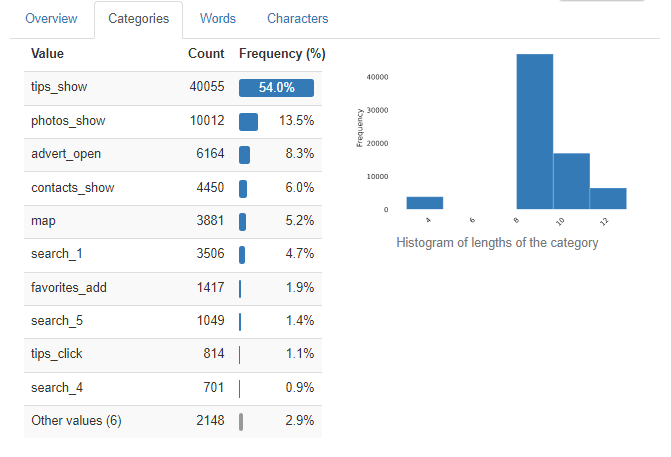

Из более чем 74 тысяч событий 40 тысяч (54 %) составляет независящее от пользователя, сгенерированное самим приложенем tips_show - показ рекомендованного объявления. При этом переходов к рекомендованному объявлению- tips_click только  1.1%. Пользователи практически не взаимодействуют с рекомендательной системой. Проблема может носить как техническй характер (не получается перейти к рекомендованному объявлению или неправильно настроен подсчет действий) так и поведенческий (такие рекомендации не интересуют пользовтеля).

Другие события происходили гораздо реже. Самое популярное, совершенное пользователем - photos_show(13.5%). Целевых действий contacts_show всего 6%, событие show_contacts вообще не попал в десятку популярных событий, их меньше 0,9%.

События search_1 — search_7 являются отдельными событиями, но последовательность не линейная, предполагаем, что четкой хронологии в этих событиях нет. Вместе с тем неочевдные названия search_1 — search_7 не позволяют сделать предположения о назначении каждого действия. Для дальнейшего исследования сгруппируем ве события поиска в одно.

Теперь подготовим датасеты к дальнейшей работе.

In [61]:
# приводим названия колонок к стандартному виду
mobile_sourсes.rename(columns = {'userId' : 'user_id'}, inplace = True)
mobile_dataset.columns = mobile_dataset.columns.str.replace(".", "_", regex=True)
# объединяем датафреймы
df = mobile_sourсes.merge(mobile_dataset, on='user_id', how='right')
# приводим значения к типу datetime
df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S').dt.floor('s')
# добавим клонку с датой события
df['date'] = pd.to_datetime(df['event_time']).dt.date
df['date'] = pd.to_datetime(df['date']).dt.normalize()
# группируем события целевого действия и события поиска
df['event_name'] = df['event_name'].str.replace('show_contacts', 'contacts_show')
df['event_name'] = df['event_name'].str.replace('search_+\d', 'search', regex=True) 
df.info()
display(df.head())
df['event_name'].value_counts().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     74197 non-null  object        
 1   source      74197 non-null  object        
 2   event_time  74197 non-null  datetime64[ns]
 3   event_name  74197 non-null  object        
 4   date        74197 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 3.4+ MB


,user_id,source,event_time,event_name,date
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,tips_show,2019-10-07
3,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:56,advert_open,2019-10-07


tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

## EDA. Исследовательский анализ

### Изучим уникальные события 

- Построим воронку по всем событиям
- Посмотрим на распределение событий по дням. Сгруппируем события по дням и названию, построим барплот,
- Посчитаем количество событий на пользователя. Сгруппируем по пользователям, суммируем количество событий, построим гистограмму,


Вполняя предобработку данных мы обратили внимание на большое количество событий сгенерированных автоматически - tips_show. Исследуя данные будем строить графики с учетом этого событияи без учета.

#### Воронка событий
Построим и изучим воронку действий, совершаемых пользователями. Для этого уберем из датасета генерируемое самим приложением действие tips_show. 

In [62]:
# пишем функцию для построения воронки

def get_funnel(data):
    events_per_users = data.groupby('event_name')['user_id']\
                           .nunique()\
                           .sort_values(ascending=False)\
                           .to_frame()\
                           .reset_index()
    events_per_users = events_per_users.rename(columns={'user_id': 'count_users'})        

    #Считаем и добавляем долю пользователей, которые хоть раз совершали событие
    events_per_users['ratio'] = round(events_per_users ['count_users']/
                                      data['user_id'].nunique()*100, 1)

    # считаем конверсию в шаг
    events_per_users['convertion_in_step'] = (round(events_per_users['count_users']/
                                                    events_per_users['count_users']\
                                                    .shift(fill_value = events_per_users.loc[0,'count_users']),2))\
                                                    .apply(lambda x: f"{x:1.1%}")
    # строим воронку

    fig = go.Figure()
    fig = go.Figure(go.Funnel(
                              y = events_per_users['event_name'],
                              x = events_per_users['count_users'],
                              textfont = {"family": "Old Standard TT, serif", "size": 400},
                              textinfo = "value+percent initial+percent previous"))
    fig.update_layout(
            height=600, width=900,
        title={'text': "Воронка действий пользователей",})
    fig.show()
    
 #Считаем, сколько пользователей совершали каждое из этих событий
df_without_tips_show = df.query('event_name != "tips_show"')

get_funnel(df_without_tips_show)

Если откинуть tips show, то видим, что самым популярным событием являются события поиска. Далее, вполне логично, идут просмотр карты и фото объявления, затем целевое событие - contacts show. Ниже видим необязательные действия. В общем цепочка собыий прослеживается, но не совсем линейная. Очевидно пользователи приходят к результату разными путями, пропуская некоторые шаги воронки.

#### Распределение событий по дням

In [63]:
# напишем функцию для вывода графика распределения событий

def get_bar_event_per_day(data_x, title_text):
    event_per_day = data_x.groupby(['date','event_name'])\
                  .agg({'event_time':'count'})\
                  .reset_index()

    event_per_day.columns = ['date', 'event_name', 'event_count']

    count_sum = event_per_day.groupby('date')\
                              .agg({'event_count':'sum'})['event_count']\
                              .reset_index()
    count_sum.columns = ['date', 'event_sum'] 

    event_per_day = event_per_day.merge(count_sum, on='date', how='left')

    # формируем график через интерактивный plotly express, 
    # что дает нам возможность посмотреть на распределение событий с учетом tips_show и без, 
    # отжав в легенде соответствующее действие
    fig_event_per_day = px.bar(event_per_day, x='date', y='event_count', color='event_name')

    fig_event_per_day.update_layout(title_text= title_text)
    fig_event_per_day.for_each_trace(lambda t: t.update(name=t.name.split("=")[0]))

    fig_event_per_day.show()
get_bar_event_per_day(df, 'Распределение событий по дням')  

Меняя настройки графика с помощью легенды нашли следующие закономерности. 
- По сравнению с началом периода пользователь стали активнее.
- В целом соотношение каждого события коррелирует с общим количеством событий, но есть исключение - map. К концу исследуемого периода картой почти не пользуются.
- Между событиями contacts show и contacts call связь слабая, также как и между tips show и tips click.

#### Сколько событий совершают пользователи

Посчитаем количество событий на пользователя. Сгруппируем по пользователям, суммируем количество событий, построим гистограмму,

,event_name
count,3586.000000
mean,9.520915
std,16.318064
min,1.000000
25%,3.000000
50%,5.000000
75%,10.000000
max,336.000000


Text(0, 0.5, 'Количество пользователей')

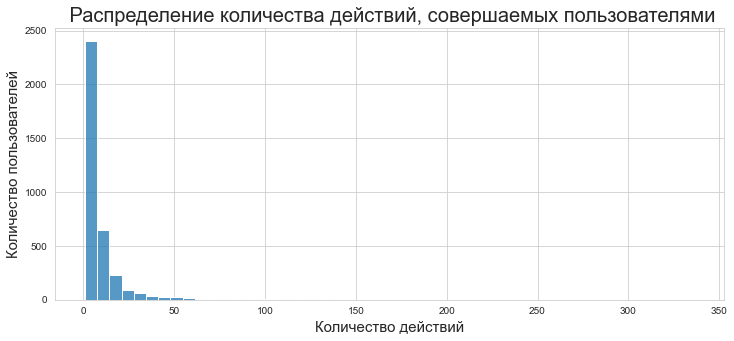

In [64]:
event_per_user = df_without_tips_show.groupby(['user_id'])\
                .agg({'event_name':'count'})\
                .sort_values(by='event_name', ascending=False)\
                .reset_index()
display(event_per_user.describe())

plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")  
sns.histplot(event_per_user['event_name'], bins=50)
plt.title(" Распределение количества действий, совершаемых пользователями", fontsize = 20)
plt.xlabel("Количество действий", fontsize = 15)
plt.ylabel("Количество пользователей", fontsize = 15)

In [65]:
percentiles = np.percentile(event_per_user['event_name'], [95, 99])
print('95 % пользователей совершает не более {} действий \n99 % пользователей совершает не более  {} действий'\
      .format(round(percentiles[0]),round(percentiles[1])))

95 % пользователей совершает не более 32 действий 
99 % пользователей совершает не более  84 действий


По describe видим, что в основном пользователи совершают от 3 до 10 действий, максимальное значение 336 дает большое отклонение от средего. Ориентируемся на медиану - 5 действий. Посчитав  перцентили видим, что 95% пользователей совершают не более 32 действий,а 99%  не более 84. График подтверждает, что большая часть пользователей совершает мало событий. Скорее всего и время сессий окажется коротким.

### Время, проведённое в приложении

- Выделим сессии для каждого пользователя, 
- Посчитаем средее время сессий, 
- Посчитаем среднее количество сессий на пользователя,
- Сделаем срез по сессиям с конверсией в целевое действие, посчитаем среднее время для этих сессий.

####  Деление событий на сессии 

Так как у нас нет данных о начале и окончании пользовательских сессий, то разделим их самостоятельно. Здесь можно довериться опыту  Google Analytics. Условием разделения станет перерыв между действиями одного пользователя более 30 минут. 

In [66]:
df['Timestamp'] = pd.to_datetime(df['event_time'])

# сортируем датасет по пользователям и событиям
# группируем и суммируем время для каждого пользователя, 
# функцией diff() определяем границу сессий -30 минут между соседними действиями
diff = (df.sort_values(['user_id', 'event_time'])\
       .groupby('user_id')['Timestamp']\
       .diff() > pd.Timedelta('30Min'))\
       .cumsum()

df['session_id'] = df.groupby(['user_id', diff], sort=False).ngroup() + 1

print('Сессий в датасете:{}'.format(len(df['session_id'].unique())))

Сессий в датасете:10368


#### Cреднее количество сессий на пользователя

,num_session
count,4293.000000
mean,2.415094
std,3.536466
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,99.000000


Text(0, 0.5, 'Количество пользователей')

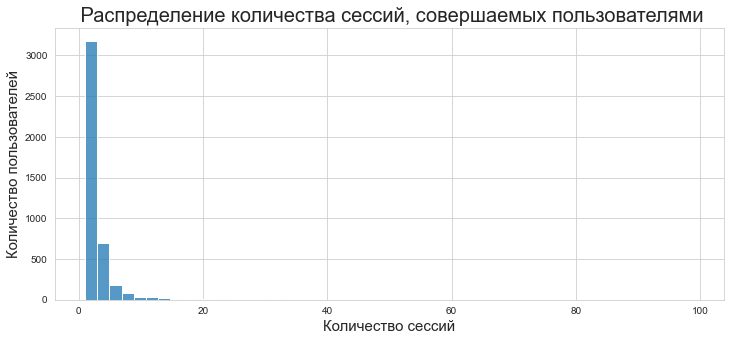

In [67]:
session_per_user = df.groupby(['user_id'])\
                .agg({'session_id':'nunique'})\
                .sort_values(by='session_id', ascending=False)\
                .reset_index()\
                .rename(columns={'session_id': 'num_session'})
display(session_per_user.describe())

plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")  
sns.histplot(session_per_user['num_session'], bins=50)
plt.title(" Распределение количества сессий, совершаемых пользователями", fontsize = 20)
plt.xlabel("Количество сессий", fontsize = 15)
plt.ylabel("Количество пользователей", fontsize = 15)

На пользоватля приходится от 1 до 3 сессий.

####  Cреднее время  пользовательских сессий

Напишем функцию для расчета описательных статистик пользовательских сессий.

In [68]:
# функция которая будет выводить описательные статистики для датасетов по длительности сессий
def get_session_time(df):
    session_time = df.groupby('session_id')['Timestamp']\
                 .agg(lambda x: max(x) - min(x))\
                 .to_frame()\
                 .rename(columns={'Timestamp': 'session_duration'})
    return session_time
# вызываем для всего датасета
get_session_time(df).describe()

,session_duration
count,10368
mean,0 days 00:12:52.672935956
std,0 days 00:19:51.613451145
min,0 days 00:00:00
25%,0 days 00:00:21
50%,0 days 00:05:35
75%,0 days 00:17:26
max,0 days 05:21:59


Видим нулевые сессии. Они сбивают статистику и нужно будет их убрать. Максимальная сессия также выглядит подозрительно.
Посчитаем перцентили и определим границу выбросов.

In [69]:
percentiles_time = df.groupby('session_id')['Timestamp']\
                 .agg(lambda x: max(x) - min(x))\
                 .to_frame()\
                 .quantile([0.01, 0.05, 0.1, 0.2, 0.24, 0.95, 0.99], numeric_only=False)
percentiles_time

,Timestamp
0.01,0 days 00:00:00
0.05,0 days 00:00:00
0.10,0 days 00:00:00
0.20,0 days 00:00:00
0.24,0 days 00:00:14
0.95,0 days 00:48:31.649999999
0.99,0 days 01:32:18


99% пользователей тратят в приложении не более полутора часов. А вот с нижней границей все еще не понятно. 20% сессиий с нулевым временем. Есть сессии продолжительностью 14 секунд. Посмотрим на аномально короткие  и длинные сессии.

Для коротких возьмем 24 перцентиль.

In [70]:
# делаем срез коротких сессий. 
short_time = "0 days 00:00:14"
short_session_time = get_session_time(df).query('session_duration < @short_time', engine='python').reset_index()
short_session_list = short_session_time['session_id'].unique()
short_session = df.query('session_id in @short_session_list')

print('Коротких сессий в датасете:{}'.format(len(short_session['session_id'].unique())))
# вызываем функцию 
get_bar_event_per_day(short_session, 'Распределение событий по дням для коротких сессий')  


Коротких сессий в датасете:2485


In [71]:
# смотрим сколько действий пришлось на кадого пользователя
short_session.groupby(['user_id'])\
             .agg({'event_name':'count'})\
             .sort_values(by='event_name', ascending=False)\
             .reset_index()\
             .describe()

,event_name
count,1238.000000
mean,2.412763
std,3.283687
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,45.000000


Сессии короткие, но похожи на настоящие. Присутствуют все виды действий, вряд ли это парсинг. На пользователя приходится 1-3 действия, что возможно. Например, открыл пуш-уведомление, посмотрел, закрыл.  Принимаем решение отбросить только нулевые сессии. 

Теперь посмотрим на длинные. 99% пользователей проводят в приложении н более 1 часа 32 минут. Сделаем срез превышающий это время.

In [72]:
# делаем срез длинных сессий
long_time = "0 days 01:32:18"
long_session_time = get_session_time(df).query('session_duration > @long_time', engine='python').reset_index()
long_session_list = long_session_time['session_id'].unique()
long_session = df.query('session_id in @long_session_list')

print('Длинных сессий в датасете:{}'.format(len(long_session['session_id'].unique())))
# вызываем функцию 
get_bar_event_per_day(long_session, 'Распределение событий по дням для длинных сессий')  


Длинных сессий в датасете:103


In [73]:
# смотрим сколько действий пришлось на кадого пользователя
long_session.groupby(['user_id'])\
            .agg({'event_name':'count'})\
            .sort_values(by='event_name', ascending=False)\
            .reset_index()\
            .describe()

,event_name
count,91.000000
mean,51.637363
std,40.337883
min,8.000000
25%,29.000000
50%,41.000000
75%,58.000000
max,243.000000


Получили всего 103 длинных сессии из более чем 10 тысяч.  Количество действий на пользователя, в основном, от 8 до 58. По графику, если отключить в легенде tips show, заметно, что очень популярны ссобытия map, advert open, contact show и favorites add. Похоже кто-то долго искал и откладывал в избранное будущие покупки.

Для дальнейшей работы сделаем срез по сессиям без аномальных значений.

In [74]:
# срез сессий по времени от 0 до 01:32:18
delta_session_time = get_session_time(df).query(' "00:00:00" != session_duration < "01:32:18"', engine='python').reset_index()
delta_session_list = delta_session_time['session_id'].unique()
df_clean = df.query('session_id in @delta_session_list')

print('Сессий в датасете осталось:{}'.format(len(df_clean['session_id'].unique())))

Сессий в датасете осталось:8118


In [75]:
# посмотрим как изменилась статистика
get_session_time(df_clean).describe()

,session_duration
count,8118
mean,0 days 00:14:47.911308203
std,0 days 00:16:18.411938509
min,0 days 00:00:01
25%,0 days 00:03:07
50%,0 days 00:09:05
75%,0 days 00:20:54
max,0 days 01:32:07


По чистым данным получили, что в основном пользователи находятся в приложении от 3 до 21 минуты. Медианное время 9 минут.

####  Среднее время пользовательских сессий содержащих целевое действие

In [76]:
# делаем срез сессий с contacts_show
target_event_session = df_clean.query('event_name == "contacts_show"')
target_num_session = target_event_session['session_id'].unique()
session_with_target = df_clean.query('session_id in @ target_num_session')

get_session_time(session_with_target).describe()


,session_duration
count,1527
mean,0 days 00:18:36.349705304
std,0 days 00:19:35.378779820
min,0 days 00:00:01
25%,0 days 00:03:34
50%,0 days 00:11:52
75%,0 days 00:26:50.500000
max,0 days 01:32:04


Для сессий, которые привели к целевому действию, медианное время выше - 11 минут. 75% пользователей тратит до 26 минут в приложении. 

#### Вывод

Исследуя временные рамки сессий нашли сессии с нулевым значением времени, а также аномально длинные. После очистки получили, что в основном пользователи находятся в приложении от 3 до 21 минуты. Медианное время 9 минут. А для сессий, в которых пользователи совершали целевое действие, время нахождения в приложении выше - от 3 до 26 минут. Медианное время для них - 11 минут.


### Сегментируем пользователей

В начале исследования мы отметили большое количество сгенерированных приложением событий tips show- показ рекомендованных объявлений. Проверим теорию, что поведение пользователей отличается в зависимости от того видят ли они рекомендации или нет.

Поделим на тех, кто во время сессии видел рекомендации и для тех, кто не видел.
Для каждой группы считаем:
- retention rate по неделям,
- конверсию в целевое действие — просмотр контактов,
- среднее время сессий,
- среднее время от начала сессии до целевого действия.

В конце исследования проведем z-тест и посмотрим есть ли отличия в конверсии между этими двумя группами.

#### Сегментация пользователей 

In [77]:
tips_show_query = df_clean.query('event_name == "tips_show"')
tips_show = tips_show_query['user_id'].unique()
users_with_tips_show = df_clean.query('user_id in @tips_show')
users_without_tips_show = df_clean.query('user_id not in @tips_show')

if len(df_clean) == len(users_with_tips_show) + len(users_without_tips_show):
    print("Датасет разделён успешно")
else:
    print('Датасет разделен неправильно')

Датасет разделён успешно


#### retention rate по сегментам

Напишем функцию для расчета retention rate по неделям и применим её к нашим сегментам. Посмотрим, как отличаются показатели.

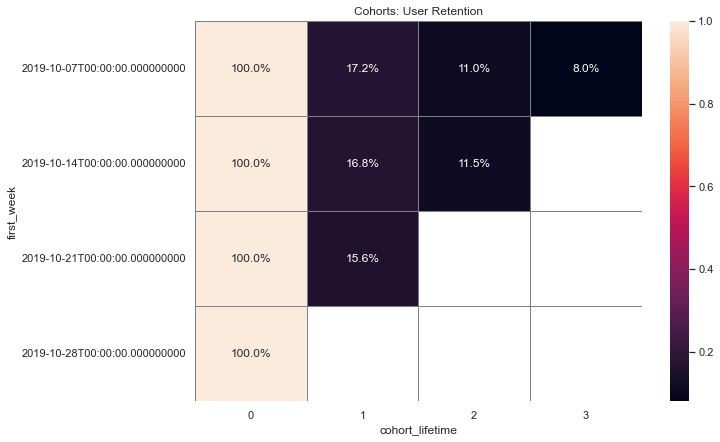

In [78]:
# пишем функцию для расчета retention rate
def get_retention(dataframe):
    # ищем дату, когда пользователь совершил первое действие
    first_date = dataframe.groupby(['user_id'])['date'].min()
    first_date.name = 'first_date'
    result_raw = dataframe.join(first_date,on='user_id')

    # ищем первый день недели, в которую пользователь совершил первое действие,
    # по нему будем собирать пользователей в когорты
    result_raw['num_week_activity'] = pd.to_datetime(
                                      result_raw['date'],unit='d') - pd.to_timedelta(result_raw['date']\
                                      .dt.dayofweek, unit='d')
    result_raw['first_week'] = pd.to_datetime(
                                      result_raw['first_date'], unit='d') - pd.to_timedelta(result_raw['first_date']\
                                      .dt.dayofweek, unit='d')

    # считаем lifetime пользователей по неделям
    result_raw['cohort_lifetime'] = result_raw['num_week_activity'] - result_raw['first_week']
    result_raw['cohort_lifetime'] = result_raw['cohort_lifetime'] / np.timedelta64(1,'W')
    result_raw['cohort_lifetime'] = result_raw['cohort_lifetime'].astype(int)

    # группируем пользователей по недельным когортам
    cohorts = result_raw.groupby(['first_week','cohort_lifetime'])\
                        .agg({'user_id':'nunique'})\
                        .reset_index()

    # считаем сколько пользователей в когорте на первый день и добавляем к cohorts
    users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_week','user_id']]
    users_count = users_count.rename(columns={'user_id':'cohort_users'})
    cohorts = cohorts.merge(users_count,on='first_week')

    # считаем Retention rate по неделям
    cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_week',columns='cohort_lifetime',values='retention',aggfunc='sum')
    return retention_pivot

# пишем функцию для отрисовки, которая на вход принимает функцию для расчета и датафрейм  
# и рисует хитмап
def get_hitmap(function, data_):    
    sns.set(style='white')
    plt.figure(figsize=(10, 7))
    plt.title('Cohorts: User Retention')
    sns.heatmap(function(data_), annot=True, fmt='.1%', linewidths=1, linecolor='gray');

    
# вызываем для 1 сегмента    
get_hitmap(get_retention, users_with_tips_show) 

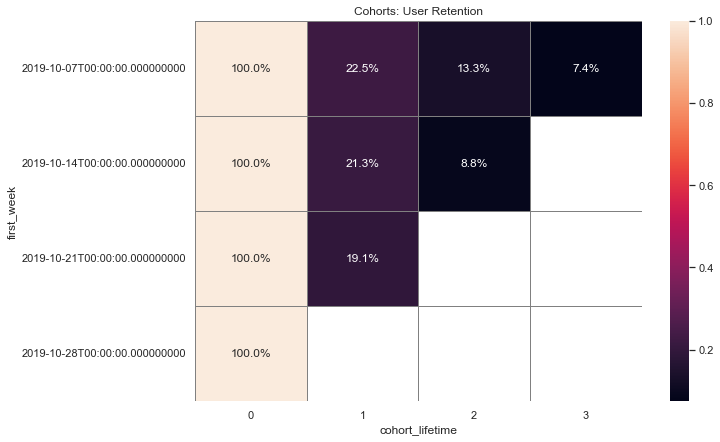

In [79]:
# вызываем для 2 сегмента  
get_hitmap(get_retention, users_without_tips_show)

По тепловым картам видим, что на 2 и 3 неделю лучше удерживаются пользователи, которые не видят рекомендательную систему. Они чаще возвращаются в приложение.

Возможно рекомендации очень навязчивы и мешают пользоваться приложением, есть и второй вариант- рекомендации не меняются. Этим грешит, например, WildBerries. На главной странице постояный набор одних и тех же карточек, основанный на вещах, находящихся в избранном. В итоге показов много- переходов мало.

На четвертую неделю показатель изменился. Больше осталось тех, кто видел рекомендации. На таком коротком периоде данных не стоит делать окончательных выводов.

#### convertion rate по сегментам

In [80]:
# посмотрим  сколько целевых действий приходится на пользователя в каждой группе

# для тех кто не видел рекомендации
target_event_per_user = users_without_tips_show.query('event_name == "contacts_show"')\
                .groupby(['user_id'])\
                .agg({'event_name':'count'})\
                .sort_values(by='event_name', ascending=False)\
                .reset_index()
# для тех кто видел рекомендации
target_event_per_user_2 = users_with_tips_show.query('event_name == "contacts_show"')\
                .groupby(['user_id'])\
                .agg({'event_name':'count'})\
                .sort_values(by='event_name', ascending=False)\
                .reset_index()


display("Для тех кто не видел рекомендации")
display(target_event_per_user.describe())
display("Для тех кто видел рекомендации")
display(target_event_per_user_2.describe())

'Для тех кто не видел рекомендации'

,event_name
count,440.000000
mean,3.472727
std,3.655331
min,1.000000
25%,1.000000
50%,2.000000
75%,4.250000
max,28.000000


'Для тех кто видел рекомендации'

,event_name
count,491.000000
mean,4.997963
std,10.266152
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,80.000000


По количеству целевых действий от 25 до 75% пользователей между группами различий нет - от 1 до 4 целевых действий. Есть разница в  максимальном количестве действий. Для тех кто  видел рекомендации - 80, для тех кто не видел рекомендации 28. Посмотрим как это сказывается на конверсии.

In [81]:
# находим количество пользователей и количество contacts_show по группам 
yes_users = users_with_tips_show['user_id'].nunique()
yes_cs = users_with_tips_show[(users_with_tips_show['event_name']=='contacts_show')]['user_id'].nunique()

no_users = users_without_tips_show['user_id'].nunique()
no_cs =  users_without_tips_show[(users_without_tips_show['event_name']=='contacts_show')]['user_id'].nunique()

# собираем в таблицу
convertion_in_target = pd.DataFrame({
    'recomendation': ['yes', 'no'],
    'all_users':[yes_users, no_users],
    'contacts_show_users':[yes_cs, no_cs]})
# добавляем % конверсии в contacts_show
convertion_in_target['convers_%'] = round(convertion_in_target['contacts_show_users'] / convertion_in_target['all_users'],4)*100
convertion_in_target.set_index(['recomendation'], inplace=True)
convertion_in_target = convertion_in_target.T
display(convertion_in_target)

recomendation,yes,no
all_users,2733.00,1455.00
contacts_show_users,491.00,440.00
convers_%,17.97,30.24


Тех, кто видел рекомендации во время сессий почти в два раза больше: 2733 против 1455. При этом лучшую конверсию в целевое показывают те, кто не видел рекомендациями - 30,24%

#### среднее время сессий

In [82]:
display("Для тех кто видел рекомендации")
get_session_time(users_with_tips_show).describe()

'Для тех кто видел рекомендации'

,session_duration
count,5303
mean,0 days 00:16:36.658306618
std,0 days 00:17:21.414342638
min,0 days 00:00:01
25%,0 days 00:03:59
50%,0 days 00:10:35
75%,0 days 00:23:23
max,0 days 01:32:04


In [83]:
display("Для тех кто не видел рекомендации")
get_session_time(users_without_tips_show).describe()

'Для тех кто не видел рекомендации'

,session_duration
count,2815
mean,0 days 00:11:23.049733570
std,0 days 00:13:28.452465602
min,0 days 00:00:01
25%,0 days 00:01:53.500000
50%,0 days 00:06:17
75%,0 days 00:16:10
max,0 days 01:32:07


Те, кто видел рекомендации, по времени близки к общим показателям по всем пользователям. Проводят в приложении в осовном  от 4 до 23 минут. Те, кто не видел рекомендации, справляются быстрее - от 2 до 16 минут.

#### Среднее время от начала сессии до целевого действия

In [84]:
sessions = session_with_target.groupby(['user_id','session_id'])\
                              .agg({'event_time' :'min'})\
                              .rename(columns={'event_time':'begin_time'})\
                              .reset_index()

cs_time = session_with_target.query('event_name == "contacts_show"')\
                             .groupby(['user_id','session_id'])\
                             .agg({'event_time' :'min'})\
                            .rename(columns={'event_time':'contacts_show_time'})

sessions = sessions.merge(cs_time, on=['user_id','session_id'], how='left')
sessions['cs'] = sessions['contacts_show_time'] - sessions['begin_time']

ts_time = session_with_target.query('event_name == "tips_show"')\
                            .groupby(['user_id','session_id'])\
                            .agg({'event_time' :'min'})\
                            .rename(columns={'event_time':'tips_show_time'})

sessions = sessions.merge(ts_time, on=['user_id','session_id'], how='left')
sessions = sessions.query('cs != "0 days 00:00:00"')
with_ts = sessions.query('tips_show_time != "NaT"')
without_ts = sessions.query('tips_show_time == "NaT"')

display("сессии с tips_show")
display(with_ts['cs'].describe())
display("сессии без tips_show")
display(without_ts['cs'].describe())


'сессии с tips_show'

count                          708
mean     0 days 00:09:33.519774011
std      0 days 00:11:11.929140959
min                0 days 00:00:01
25%         0 days 00:01:33.250000
50%                0 days 00:05:23
75%         0 days 00:13:17.750000
max                0 days 01:11:28
Name: cs, dtype: object

'сессии без tips_show'

count                          407
mean     0 days 00:08:03.825552825
std      0 days 00:10:56.205555125
min                0 days 00:00:03
25%                0 days 00:01:10
50%                0 days 00:03:43
75%                0 days 00:10:06
max                0 days 01:12:49
Name: cs, dtype: object

И здесь  пользующиеся только поиском показывают лучшее время. Им до выполнения целевого действия достаточно от 1 минуты до 10, в отличие от тех, кто видел рекомендации, им нужно от 1,5 до 13 минут. Медианное время 3 и 5 минут соответственно.

#### Вывод

Сегментировав пользователей по принципу видел рекомендации / не видел получили, что те, кто не отвлекается на рекомендации  в целом лучше удерживаются(retention rate почти все время выше), показывают лучшую конверсию в целевое действие(30.24% против 17.97%) и доходят до него быстрее(медианное время 3 против 5 минут). Это сказывается на общем времени, проводимом в приложении.
Сессии короче - большинство от 1 до 10 минут, против 1,5 до 13 минут для сессий с рекомендациями.

Приходим к выводу, что рекомендательная система скорее мешает, чем помогает. Учитывая, что конверсия из просмотра рекомендованнного объявления в переход к этому объявлению запредельно низкая стоит изучить более детально пользовательский опыт взаимодействия с рекомендациями и пересмотреть параметры формирования рекомендаций.

## Проверка статистических гипотез 

### Проверка статистической гипотезы по ТЗ

Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

**H₀** Нет статистических различий в конверсии в просмотры контактов для пользователей, установивших приложение через yandex и установивших прилодение через google.

**H₁** Есть статистические различия в конверсии в просмотры контактов для пользователей, установивших приложение через yandex и установивших прилодение через google.

- Фильтруем датафрейм. Оставляем сессии в которых есть целевое событие, session_with_target
- Разбиваем отфильтрованный датафрейм по источнику привлечения,
- Сравниваем группы с помощью z-критерия.


Сформируем датафрейм и проверим гипотезу о наличии статистически значимой разницы с помощью z-критерия:

In [87]:
# находим количество пользователей и количество contacts_show по группам 
yandex_users = df[df['source']=='yandex']['user_id'].nunique()
yandex_cs = df[(df['source']=='yandex')&(df['event_name']=='contacts_show')]['user_id'].nunique()

google_users = df[df['source']=='google']['user_id'].nunique()
google_cs = df[(df['source']=='google')&(df['event_name']=='contacts_show')]['user_id'].nunique()

# собираем в таблицу
target = pd.DataFrame({
    'source': ['yandex', 'google'],
    'all_users':[yandex_users, google_users],
    'contacts_show_users':[yandex_cs, google_cs]})
# добавляем % конверсии в contacts_show
target['convers_%'] = round(target['contacts_show_users'] / target['all_users'],4)*100
target.set_index(['source'], inplace=True)
target = target.T
target

source,yandex,google
all_users,1934.00,1129.00
contacts_show_users,478.00,275.00
convers_%,24.72,24.36


In [88]:
# функция для подсчета Z-критерия
def z_test(table, value_1, value_2, event, alpha): 
    
    p1_ev = table.loc[event, value_1] # отбираем событие и количество значений для первой группы
    p2_ev = table.loc[event, value_2] # отбираем событие и количество значений для второй группы
    
    p1_us = table.iloc[0][0] # количество человек в первой группе
    p2_us = table.iloc[0][1] # количество человек во второй группе
    
    p1 = p1_ev / p1_us # пропорция успехов в первой группе
    p2 = p2_ev / p2_us # пропорция успехов во второй группе
    
    difference = p1 - p2 # разница пропорций в датасетах
    
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) # пропорция успехов в комбинированном датасете
    
    # считаем статистику  по общепринятой формуле Z-критерия
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    
    distr = st.norm(0, 1)# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Для групп {} и {} по событию: {}'.format(value_1, value_2, event))
    print('p-value: {}'.format(p_value))
        
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

display(target)       
z_test(target, 'yandex', 'google', "contacts_show_users", 0.05) 

source,yandex,google
all_users,1934.00,1129.00
contacts_show_users,478.00,275.00
convers_%,24.72,24.36


Для групп yandex и google по событию: contacts_show_users
p-value: 0.8244316027993777
Не получилось отвергнуть нулевую гипотезу


Проведя статистический тест мы не смогли отвергнть гипотезу о различии в конверсии для пользователей, пришедших к нам из разных источников. Приходим к выводу что нет статистически значимых различий между пользовтелями пришедшими к нам через yandex и google/

### Проверка дополнительной статистической гипотезы

Есть предположение, что конверсия в целевое действие для тех, кто нашел товар через рекомендации и тех, кто искал только через поиск отличаются.

**H₀** Конверсия в show_contacts для рекомендованного товара и для найденного пользователем самостоятельно не отличаются.

**H₁** Конверсия в show_contacts для рекомендованного товара и для найденного пользователем самостоятельно отличаются.
- Разбиваем отфильтрованный датафрейм на сессии с рекомендациями и без,
- Сравниваем группы с помощью z-критерия.

In [89]:
z_test(convertion_in_target, 'yes', 'no', "contacts_show_users", 0.05)

Для групп yes и no по событию: contacts_show_users
p-value: 0.0
Отвергаем нулевую гипотезу


Проведя статистический тест по конверсии в целевое действие между группами пользователей, которые пользовались рекомендациями, и которые не пользовались получили ожидаемый ответ- различия в конверсии есть.

## Общие выводы и рекомендации

Выполняя исследование нужно было разобраться, как ведут себя пользователи мобильного приложения для продажи ненужных вещей. 

Изучив логи пользовательских действий нашли, что:

Из более чем 74 тысяч событий 40 тысяч (54 %) составляет независящее от пользователя, сгенерированное самим приложенем tips_show - показ рекомендованного объявления. При этом переходов к рекомендованному объявлению- tips_click только 1.1%. Пользователи практически не взаимодействуют с рекомендательной системой. Проблема может носить как техническй характер (не получается перейти к рекомендованному объявлению или неправильно настроен подсчет действий) так и поведенческий (такие рекомендации не интересуют пользовтеля).

Другие события происходили гораздо реже. Самое популярное, совершенное пользователем - photos_show(13.5%). Целевых действий contacts_show всего 6%, событие show_contacts вообще не попал в десятку популярных событий, их меньше 0,9%.

События search_1 — search_7 являются отдельными событиями, но последовательность не линейная, четкой хронологии в этих событиях нет. Вместе с тем неочевдные названия search_1 — search_7 не позволяют сделать предположения о назначении каждого действия. Для дальнейшего исследования сгруппировали все события поиска в одно общее search.

В начале исследования мы отметили большое количество сгенерированных приложением событий tips show- показ рекомендованных объявлений. Возникла теория, что поведение пользователей отличается в зависимости от того видят ли они рекомендации или нет. Было решено сегментировать пользователей на 2 группы: на тех, кто во время сессии видел рекомендации и для тех, кто не видел. 

Сегментировав пользователей по этому принципу получили, что те, кто не отвлекается на рекомендации в целом лучше удерживаются(retention rate почти все время выше), показывают лучшую конверсию в целевое действие(30.24% против 17.97%) и доходят до него быстрее(медианное время 3 против 5 минут). Это сказывается на общем времени, проводимом в приложении. Сессии короче - большинство от 1 до 10 минут, против 1,5 до 13 минут для сессий с рекомендациями.

Приходим к выводу, что рекомендательная система скорее мешает, чем помогает. Возможно рекомендации очень навязчивы и мешают пользоваться приложением, есть и второй вариант- рекомендации не меняются. Этим грешит, например, Wildberies. На главной странице постояный набор одних и тех же карточек, основанный на вещах, находящихся в избранном. В итоге показов много- переходов мало.

Учитывая, что конверсия из просмотра рекомендованнного объявления в переход к этому объявлению запредельно низкая стоит порекомендовать изучить более детально пользовательский опыт взаимодействия с рекомендациями и пересмотреть параметры формирования рекомендаций. Разобравшись в причинах плохой конверсии в просмотр рекомендованного товара удастся повысить общую конверсию в целевое действие, тем самым улучшим работу всего приложения в целом и повысим монетизацию.
